In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from pprint import pprint
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from feature_engine.creation import CyclicalTransformer
from matplotlib.dates import DateFormatter
import os
from skimage.io import imread, imshow
from skimage.color import rgba2rgb
from skimage.transform import resize
from skimage.filters import sobel

In [117]:
# Load CSV to Dataframe
#PATH = 'data/'
FILE_train = 'XYtr.csv'
FILE_test = 'Xte.csv'

#raw_train = pd.read_csv(PATH + FILE_train)
#raw_test = pd.read_csv(PATH + FILE_test)
raw_train = pd.read_csv(FILE_train)
raw_test = pd.read_csv(FILE_test)

# Description, version, symbol, fee1, and fee2 have missing values (NaN)
print(raw_train.info())
print()
print(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3   description  6512 non-null   object 
 4   version      6746 non-null   object 
 5   symbol       5555 non-null   object 
 6   ext          6914 non-null   object 
 7   fee1         6696 non-null   float64
 8   fee2         6705 non-null   float64
 9   total        6914 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 540.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3 

In [118]:
print('raw_train shape: ', raw_train.shape)
print('raw_test shape: ', raw_test.shape)

raw_train shape:  (6914, 10)
raw_test shape:  (6914, 9)


In [119]:
train_clean = raw_train.copy()
test_clean = raw_test.copy()

# description: use the token None to mean no description
train_clean['description'] = train_clean['description'].fillna('None')

# version: Has 'None' category. Set nan to 'None'. 
#print(train_train['version'].unique())
train_clean['version'] = train_clean['version'].fillna('None')

# symbol: 5 digit symbols. Set to 00000 to represent None.
# print(df_train['symbol'].unique())
train_clean['symbol'] = train_clean['symbol'].fillna('00000')


# fee1: Small number misssin. Fill with the mean.
#df_train['fee1'] = df_train['fee1'].fillna((df_train['fee1'].mean()))
# https://www.w3resource.com/python-exercises/pandas/missing-values/python-pandas-missing-values-exercise-14.php
train_clean['fee1'].fillna(train_clean['fee1'].median(), inplace=True)
                                           
# fee2: Small number misssin. Fill with the mean.
#df_train['fee2'] = df_train['fee2'].fillna((df_train['fee2'].mean()))
train_clean['fee2'].fillna(train_clean['fee2'].median(), inplace=True)


print(train_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3   description  6914 non-null   object 
 4   version      6914 non-null   object 
 5   symbol       6914 non-null   object 
 6   ext          6914 non-null   object 
 7   fee1         6914 non-null   float64
 8   fee2         6914 non-null   float64
 9   total        6914 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 540.3+ KB
None


In [120]:
# description: use the token None to mean no description
test_clean['description'] = test_clean['description'].fillna('None')

# version: Has 'None' category. Set nan to 'None'. 
test_clean['version'] = test_clean['version'].fillna('None')

# symbol: 5 digit symbols. Set to 00000 to represent None.
test_clean['symbol'] = test_clean['symbol'].fillna('00000')

# fee1: Small number misssin. Fill with the mean.
test_clean['fee1'].fillna(test_clean['fee1'].median(), inplace=True)
                                           
# fee2: Small number misssin. Fill with the mean.
test_clean['fee2'].fillna(test_clean['fee2'].median(), inplace=True)


print(test_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6914 non-null   object 
 1   X.sales      6914 non-null   int64  
 2   cdate        6914 non-null   object 
 3   description  6914 non-null   object 
 4   version      6914 non-null   object 
 5   symbol       6914 non-null   object 
 6   ext          6914 non-null   object 
 7   fee1         6914 non-null   float64
 8   fee2         6914 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 486.3+ KB
None


In [121]:
train_processed = train_clean.copy()
test_processed = test_clean.copy()


In [122]:
# cdate: change dates to float
tr_date = train_processed['cdate']
train_processed['cdate'] = pd.to_datetime(tr_date).values.astype(np.float64)/8.64e+13

te_date = test_processed['cdate']
test_processed['cdate'] = pd.to_datetime(te_date).values.astype(np.float64)/8.64e+13

In [123]:
# X.sales: change from int to float
train_processed['X.sales'] = train_processed['X.sales'].astype(np.float64)
test_processed['X.sales'] = test_processed['X.sales'].astype(np.float64)

In [124]:
# obtain unique values from each dataset
train_symbols = set(train_processed['symbol'].unique())
test_symbols = set(test_processed['symbol'].unique())

# union all the values
# https://stackoverflow.com/questions/52976664/python-differences-between-two-lists
# # https://www.programiz.com/python-programming/methods/set/union
all_symbols = train_symbols.union(test_symbols)

# values not included in train set
train_required_symbols = list(all_symbols - train_symbols)

# values not included in test set
test_required_symbols = list(all_symbols - test_symbols)

In [125]:
# one-hot encoding on version, symbol and ext
train_processed = pd.get_dummies(train_processed, columns = ['version', 'ext', 'symbol'], drop_first = False, prefix = ['version', 'ext', 'symbol'])
test_processed = pd.get_dummies(test_processed, columns = ['version', 'ext', 'symbol'], drop_first = False, prefix = ['version', 'ext', 'symbol'])

In [126]:
# https://stackoverflow.com/questions/18674064/how-do-i-insert-a-column-at-a-specific-column-index-in-pandas
for train_syms in train_required_symbols:
    train_processed.insert(train_processed.shape[1], str('symbol_') + train_syms, 0)
train_base = train_processed.copy()

/Users/Jamie/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [127]:
for test_syms in test_required_symbols:
    test_processed.insert(test_processed.shape[1], str('symbol_') + test_syms, 0)
test_base = test_processed.copy()

In [128]:
train_base = train_processed.copy()

In [129]:
test_base = test_processed.copy()

In [130]:

# Check for missing values before processing
print('train description missing values: ', train_base['description'].isnull().sum())
print('test description missing values: ', test_base['description'].isnull().sum())

train description missing values:  0
test description missing values:  0


In [131]:
# Create corpus using training and test data
corpus = list(train_base['description'])+list(test_base['description'])

In [132]:
# Create a Vectorizer Object
# remove tokens that appear in 10% of the documents
# remove unique tokens that appear in, at most, 2 documents
vectorizer = CountVectorizer(max_df=0.1, min_df=2)

In [133]:

# Encode the documents in a count matrix
corpus_vectorized = vectorizer.fit_transform(corpus)

In [134]:
# Feature names and size
print('feature name: ', vectorizer.get_feature_names_out())
print('feature size: ', len(vectorizer.get_feature_names_out()))

# dimension of a sparse matrix of documents (row) vs number of unique words
print('matrix dimension: ', corpus_vectorized.shape)

feature name:  ['002n7' '00b0d' '00jhg' ... 'zztgg' 'zzvdf' 'zzw3j']
feature size:  10566
matrix dimension:  (13828, 10566)


In [136]:
# A sparse matrix of documents (row) vs number of unique words
count_array = corpus_vectorized.toarray()
corpus_df = pd.DataFrame(data=count_array,columns = vectorizer.get_feature_names_out())
corpus_df

,002n7,00b0d,00jhg,00ud9,00xck,01abs,01fnu,01jsj,01k0e,01nrz,...,zzhb3,zzht0,zzlz3,zznp1,zzns7,zzpvk,zzr1c,zztgg,zzvdf,zzw3j
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:

lda_model = LatentDirichletAllocation(n_components = 10,
                                     learning_method = 'online',
                                      learning_decay = 0.9,
                                      random_state=100, 
                                      batch_size=128, 
                                      evaluate_every = -1, 
                                      n_jobs = -1)

lda_output = lda_model.fit_transform(corpus_vectorized)

In [138]:
print(lda_output.shape)
print(lda_model)

(13828, 10)
LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          n_jobs=-1, random_state=100)


In [139]:

topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
train_document_topic = pd.DataFrame(np.round(lda_output[0:6914,], 8), columns = topicnames)
test_document_topic = pd.DataFrame(np.round(lda_output[6914:13828,], 8), columns = topicnames)

In [140]:
train_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0.005557,0.005556,0.005558,0.005556,0.005556,0.005556,0.005556,0.005556,0.949996,0.005556
1,0.016667,0.016667,0.016667,0.016685,0.016667,0.016667,0.016667,0.016667,0.849981,0.016667
2,0.700000,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
3,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.096422,0.004167,0.870244
4,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
...,...,...,...,...,...,...,...,...,...,...
6909,0.054822,0.001961,0.001961,0.001961,0.001961,0.159625,0.001961,0.771827,0.001961,0.001961
6910,0.033333,0.699989,0.033333,0.033333,0.033344,0.033333,0.033333,0.033333,0.033333,0.033333
6911,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.971875,0.003125
6912,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.909998,0.010000


In [141]:

test_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0.009091,0.009092,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091,0.918179
1,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2,0.188026,0.007692,0.007693,0.007694,0.007696,0.007697,0.229133,0.368083,0.168595,0.007692
3,0.558962,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.157168,0.226540,0.037973
4,0.012500,0.012500,0.012500,0.012500,0.887499,0.012500,0.012500,0.012501,0.012500,0.012500
...,...,...,...,...,...,...,...,...,...,...
6909,0.001220,0.001220,0.001220,0.001220,0.001220,0.001220,0.989024,0.001220,0.001220,0.001220
6910,0.088165,0.093327,0.002564,0.154617,0.002564,0.002564,0.002564,0.648506,0.002564,0.002564
6911,0.025001,0.025000,0.025000,0.025000,0.525000,0.025000,0.274999,0.025000,0.025000,0.025000
6912,0.004762,0.004762,0.004762,0.004762,0.957142,0.004762,0.004762,0.004762,0.004762,0.004762


In [ ]:
IMAGE_FOLDER ='/Users/Jamie/venv/images/images'

In [142]:
#Image Processing: get list of filenames and read images into data-frame


images = os.listdir(IMAGE_FOLDER)
image_sizes = []
file_names = []
for image_file in images:
    file_names.append(image_file[:-4])
    image = imread('{}/{}'.format(IMAGE_FOLDER, image_file))
    if len(image.shape) == 2:
        height, width  = image.shape
        shape = (height, width, 0)
    else:
        shape = image.shape
    height, width, channels = shape
    image_sizes.append([height, width, channels])

image_df = pd.DataFrame(image_sizes, columns=['height', 'width', 'channels'])
image_df.describe()


,height,width,channels
count,8866.000000,8866.000000,8866.000000
mean,26.243515,25.557861,3.597000
std,205.798354,203.909154,0.975335
min,4.000000,15.000000,0.000000
25%,15.000000,15.000000,4.000000
50%,15.000000,15.000000,4.000000
75%,15.000000,15.000000,4.000000
max,7200.000000,6810.000000,4.000000


In [143]:
image_df['id'] = file_names
print(image_df)

      height  width  channels                                id
0         15     15         4  441867138fde60f8f6383a7473495bb7
1         15     15         3  fbc1760fa9559aa945d876bcb844846c
2         15     15         4  9296d9683e05e247964067ba474624b8
3         14     15         4  d6cad9b97497746f6fd54cd9f44a72ca
4         15     15         4  ecce7b6dd7d9b56ef615ba1256092c71
...      ...    ...       ...                               ...
8861      11     15         3  91bac11c1a918624d5f003a072e97e94
8862      15     15         4  20e5e2cc3b755786e38f95ddef786e80
8863      21     15         4  13e2d6ede635ba52651a79c682b7947e
8864      15     15         4  a94c79f8278f537f678976a12853f789
8865      11     15         4  b6a73ed4dd51c2b278d2be045b36f76b

[8866 rows x 4 columns]


In [144]:
#adds an indicator variable for greyscale images
#https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o

def greyscale (row):
    if row['channels'] == 0:
        return 1
    return 0

#image_df.apply (lambda row: greyscale(row), axis=1)
image_df['greyscale'] = image_df.apply (lambda row: greyscale(row), axis=1)


In [145]:
#adds an indicator variable for large images
def large_image (row):
    if (row['height'] > 200)|(row['width'] > 200):
        return 1
    return 0

#image_df.apply (lambda row: large_image(row), axis=1)
image_df['large_image'] = image_df.apply (lambda row: large_image(row), axis=1)

(14, 15, 3)
(14, 15, 3)


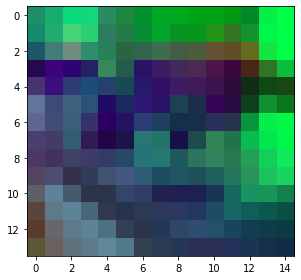

In [146]:
sample_image = 'ffc14dfa2038d68cf4f67ad39906addd.gif'
image = imread('{}/{}'.format(IMAGE_FOLDER, sample_image))
image = rgba2rgb(image)
print(image.shape)
testimage = resize(image, (15, 15))
print(image.shape)

imshow(image)

In [147]:

'''
FEATURE EXTRACTION: Mean RGB Value (unused)
'''

#height, width, channels = image.shape
#mean_pixel_matrix = np.zeros((height, width))

#for h in range(height):
#    for w in range(width):
#        mean_pixel_matrix[h][w] = (image[h][w][0] + image[h][w][1] + image[h][w][2])/channels

#mean_pixel_matrix = mean_pixel_matrix.reshape(height * width, -1)
#print(mean_pixel_matrix)
#np.mean(mean_pixel_matrix)

[[0.36078431]
 [0.39738562]
 [0.45751634]
 [0.46535948]
 [0.36339869]
 [0.30065359]
 [0.25228758]
 [0.26405229]
 [0.26143791]
 [0.24052288]
 [0.24052288]
 [0.22352941]
 [0.23267974]
 [0.4130719 ]
 [0.43006536]
 [0.3503268 ]
 [0.41568627]
 [0.5254902 ]
 [0.47843137]
 [0.34640523]
 [0.29673203]
 [0.2627451 ]
 [0.28104575]
 [0.24836601]
 [0.24313725]
 [0.26405229]
 [0.26405229]
 [0.27581699]
 [0.41830065]
 [0.43006536]
 [0.28496732]
 [0.40784314]
 [0.49803922]
 [0.38431373]
 [0.33856209]
 [0.27320261]
 [0.29281046]
 [0.32156863]
 [0.29934641]
 [0.29934641]
 [0.30457516]
 [0.27712418]
 [0.31372549]
 [0.4130719 ]
 [0.43006536]
 [0.16601307]
 [0.24705882]
 [0.21830065]
 [0.22091503]
 [0.36993464]
 [0.26666667]
 [0.21176471]
 [0.24705882]
 [0.26143791]
 [0.26013072]
 [0.22222222]
 [0.16862745]
 [0.17647059]
 [0.26405229]
 [0.34248366]
 [0.3124183 ]
 [0.25882353]
 [0.29019608]
 [0.29281046]
 [0.27189542]
 [0.24183007]
 [0.22614379]
 [0.22222222]
 [0.24705882]
 [0.23529412]
 [0.20522876]
 [0.15

0.29500778089013385

In [148]:


#adds the meanRGB value as a feature (unused)
#meanRGB=[]

#for image_file in images:
#    image = imread('{}/{}'.format(IMAGE_FOLDER, image_file))
#    if image.shape == (..., 4):
        
#        image = rgba2rgb(image)
        
    
#    height, width, channels = image.shape
#    mean_pixel_matrix = np.zeros((height, width))

#    for h in range(height):
#        for w in range(width):
#            mean_pixel_matrix[h][w] = (image[h][w][0] + image[h][w][1] + image[h][w][2])/channels

#    mean_pixel_matrix = mean_pixel_matrix.reshape(height * width, -1)
#    mmpm=np.mean(mean_pixel_matrix)
#    meanRGB.append([mmpm])
   
    




/var/folders/mq/qrk2b3yj28dcrt8fdwkh2p3r0000gn/T/ipykernel_7160/165886869.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  mean_pixel_matrix[h][w] = (image[h][w][0] + image[h][w][1] + image[h][w][2])/channels


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:

'''
FEATURE EXTRACTION: Edges (Sobel edge detection) (unused)
'''

# Find an image we can use that has more distinguishable edges
#sample_image = 'fec874e713388b45ef26c4373aba16a5.jpg'
#image = imread('{}/{}'.format(IMAGE_FOLDER, sample_image), as_gray=True)

#edge_sobel = sobel(image)

#fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
#axes[0].imshow(image, cmap=plt.cm.gray)
#axes[0].set_title('Original')

#axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
#axes[1].set_title('Sobel Edge Detection')

#for ax in axes:
    ax.axis('off')

#plt.tight_layout()
#plt.show()

In [ ]:
print(image_df)


In [ ]:
#pe-process the date information
df_train_dates = train_base[['cdate', 'total', 'X.sales']].copy()
df_train_dates['cdate'] = df_train_dates['cdate'].astype('datetime64[ns]')
df_train_dates = df_train_dates.sort_values(by='cdate').reset_index(drop=True)

df_train_dates

In [ ]:
df_test_dates = test_base[['cdate', 'X.sales']].copy()
df_test_dates['cdate'] = df_test_dates['cdate'].astype('datetime64[ns]')
df_test_dates = df_test_dates.sort_values(by='cdate').reset_index(drop=True)

df_test_dates.head()

In [38]:

'''
We want to preserve the cyclical nature of MM and D as features. One-hot encode year.
'''
df_train_dates = train_base[['cdate']].copy()
df_train_dates['cdate'] = df_train_dates['cdate'].astype('datetime64[ns]')
df_train_dates['month'] = pd.DatetimeIndex(df_train_dates['cdate']).month
df_train_dates['day'] = pd.DatetimeIndex(df_train_dates['cdate']).day
df_train_dates.head()

cyclical = CyclicalTransformer(variables=None, drop_original=True)
df_train_dates_new = cyclical.fit_transform(df_train_dates)
df_train_dates_final=df_train_dates_new.drop(['cdate'], axis=1)
print(df_train_dates_final)

         month_sin  month_cos       day_sin  day_cos
0    -2.449294e-16        1.0 -2.449294e-16      1.0
1    -2.449294e-16        1.0 -2.449294e-16      1.0
2    -2.449294e-16        1.0 -2.449294e-16      1.0
3    -2.449294e-16        1.0 -2.449294e-16      1.0
4    -2.449294e-16        1.0 -2.449294e-16      1.0
...            ...        ...           ...      ...
6909 -2.449294e-16        1.0 -2.449294e-16      1.0
6910 -2.449294e-16        1.0 -2.449294e-16      1.0
6911 -2.449294e-16        1.0 -2.449294e-16      1.0
6912 -2.449294e-16        1.0 -2.449294e-16      1.0
6913 -2.449294e-16        1.0 -2.449294e-16      1.0

[6914 rows x 4 columns]


In [39]:
#Now do the same for the testing set:

df_test_dates = test_base[['cdate']].copy()
df_test_dates['cdate'] = df_test_dates['cdate'].astype('datetime64[ns]')
df_test_dates['month'] = pd.DatetimeIndex(df_test_dates['cdate']).month
df_test_dates['day'] = pd.DatetimeIndex(df_test_dates['cdate']).day
df_test_dates.head()

cyclical = CyclicalTransformer(variables=None, drop_original=True)
df_test_dates_new = cyclical.fit_transform(df_test_dates)
print(df_test_dates_new.head())

                          cdate     month_sin  month_cos       day_sin  \
0 1970-01-01 00:00:00.000018039 -2.449294e-16        1.0 -2.449294e-16   
1 1970-01-01 00:00:00.000018012 -2.449294e-16        1.0 -2.449294e-16   
2 1970-01-01 00:00:00.000018262 -2.449294e-16        1.0 -2.449294e-16   
3 1970-01-01 00:00:00.000018715 -2.449294e-16        1.0 -2.449294e-16   
4 1970-01-01 00:00:00.000018012 -2.449294e-16        1.0 -2.449294e-16   

   day_cos  
0      1.0  
1      1.0  
2      1.0  
3      1.0  
4      1.0  


In [158]:
#Concatenate the the orignal data together with the cyclized dates and the text data
train_concatenated_dates = pd.concat([train_base, df_train_dates_new], axis=1)

In [159]:
train_concatenated = pd.concat([train_concatenated_dates, train_document_topic], axis=1)
print(train_concatenated['cdate'])

        cdate                         cdate
0     18012.0 1970-01-01 00:00:00.000018012
1     18561.0 1970-01-01 00:00:00.000018561
2     18012.0 1970-01-01 00:00:00.000018012
3     18012.0 1970-01-01 00:00:00.000018012
4     18012.0 1970-01-01 00:00:00.000018012
...       ...                           ...
6909  18593.0 1970-01-01 00:00:00.000018593
6910  18012.0 1970-01-01 00:00:00.000018012
6911  18024.0 1970-01-01 00:00:00.000018024
6912  18790.0 1970-01-01 00:00:00.000018790
6913  18544.0 1970-01-01 00:00:00.000018544

[6914 rows x 2 columns]


In [160]:
test_concatenated_dates = pd.concat([test_base, df_test_dates_new], axis=1)

In [161]:
test_concatenated = pd.concat([test_concatenated_dates, test_document_topic], axis=1)

In [162]:
#remove extraneous cdate column
train_concatenated = train_concatenated.loc[:,~train_concatenated.columns.duplicated()]
print(train_concatenated['cdate'])

0       18012.0
1       18561.0
2       18012.0
3       18012.0
4       18012.0
         ...   
6909    18593.0
6910    18012.0
6911    18024.0
6912    18790.0
6913    18544.0
Name: cdate, Length: 6914, dtype: float64


In [163]:
test_concatenated = test_concatenated.loc[:,~test_concatenated.columns.duplicated()]

In [164]:
train_merged= train_concatenated.merge(image_df, how='left', on='id')
print(train_merged)

                                    id  X.sales    cdate  \
0     a44a5f4c5e13910205404271e750e7bc      1.0  18012.0   
1     5cd06ad38bc1e842b7f3e37210b8e574     42.0  18561.0   
2     239eff19cbe449331801cd1e89c84d2c      3.0  18012.0   
3     5034105b2e14a5d71522ed8054db89ac      4.0  18012.0   
4     ab4d2c1023ad1b13f937988ea8cae5f4      1.0  18012.0   
...                                ...      ...      ...   
6909  b8b18cdc1f066586eb2a3c5326d2bb66      3.0  18593.0   
6910  d3cc7ebd0a8001ede39dfebcc05cf9be      2.0  18012.0   
6911  1912ac374a2e56327989f468cc4f09b9      2.0  18024.0   
6912  22907775e92c304ccf77744d9c1989be      2.0  18790.0   
6913  62defe67d57479ab0cd6d1ffb6525cbb      4.0  18544.0   

                                            description    fee1    fee2  \
0     uSuuw tPc2s Oh5hm kbWyC oIv2i LmM6m TfoFy gnYR...   250.0   500.0   
1                   zfG9T CWIL9 EPGsh RfQUu EDiBa hdBO7   250.0   500.0   
2     UHWIX Csin3 giC2q uSw1I B58A7 F3KFu coELQ 7OFT..

In [165]:
#Drop the less redundant image variables and remove 'description' and 'id'
train_merged = train_merged.drop(['id', 'description', 'channels', 'height', 'width'], axis=1)
print(train_merged)

      X.sales    cdate    fee1    fee2   total  version_1  version_2  \
0         1.0  18012.0   250.0   500.0   0.055          0          0   
1        42.0  18561.0   250.0   500.0  75.000          0          0   
2         3.0  18012.0   750.0  1000.0   0.158          0          0   
3         4.0  18012.0   750.0  1000.0   1.990          0          0   
4         1.0  18012.0   300.0   550.0   1.000          0          0   
...       ...      ...     ...     ...     ...        ...        ...   
6909      3.0  18593.0   750.0  1000.0   0.550          0          0   
6910      2.0  18012.0   750.0  1000.0   0.100          0          0   
6911      2.0  18024.0     0.0   250.0   0.966          0          0   
6912      2.0  18790.0   200.0   450.0   0.170          0          0   
6913      4.0  18544.0  1000.0  1250.0   0.100          0          0   

      version_3  version_4  version_None  ...    Topic2    Topic3    Topic4  \
0             1          0             0  ...  0.005558 

In [166]:
test_merged= test_concatenated.merge(image_df, how='left', on='id')
print(train_merged)

      X.sales    cdate    fee1    fee2   total  version_1  version_2  \
0         1.0  18012.0   250.0   500.0   0.055          0          0   
1        42.0  18561.0   250.0   500.0  75.000          0          0   
2         3.0  18012.0   750.0  1000.0   0.158          0          0   
3         4.0  18012.0   750.0  1000.0   1.990          0          0   
4         1.0  18012.0   300.0   550.0   1.000          0          0   
...       ...      ...     ...     ...     ...        ...        ...   
6909      3.0  18593.0   750.0  1000.0   0.550          0          0   
6910      2.0  18012.0   750.0  1000.0   0.100          0          0   
6911      2.0  18024.0     0.0   250.0   0.966          0          0   
6912      2.0  18790.0   200.0   450.0   0.170          0          0   
6913      4.0  18544.0  1000.0  1250.0   0.100          0          0   

      version_3  version_4  version_None  ...    Topic2    Topic3    Topic4  \
0             1          0             0  ...  0.005558 

In [167]:
test_merged = test_merged.drop(['id', 'description', 'channels','height','width'], axis=1)
print(train_merged)

      X.sales    cdate    fee1    fee2   total  version_1  version_2  \
0         1.0  18012.0   250.0   500.0   0.055          0          0   
1        42.0  18561.0   250.0   500.0  75.000          0          0   
2         3.0  18012.0   750.0  1000.0   0.158          0          0   
3         4.0  18012.0   750.0  1000.0   1.990          0          0   
4         1.0  18012.0   300.0   550.0   1.000          0          0   
...       ...      ...     ...     ...     ...        ...        ...   
6909      3.0  18593.0   750.0  1000.0   0.550          0          0   
6910      2.0  18012.0   750.0  1000.0   0.100          0          0   
6911      2.0  18024.0     0.0   250.0   0.966          0          0   
6912      2.0  18790.0   200.0   450.0   0.170          0          0   
6913      4.0  18544.0  1000.0  1250.0   0.100          0          0   

      version_3  version_4  version_None  ...    Topic2    Topic3    Topic4  \
0             1          0             0  ...  0.005558 

In [168]:
#'Nan's to zero

#train_merged['height'] = train_merged['height'].fillna(train_merged['height'].mean(), inplace=True)
#train_merged['width']=train_merged['width'].fillna(train_merged['width'].median(), inplace=True)
train_merged['greyscale']=train_merged['greyscale'].fillna(0)
train_merged['large_image'] = train_merged['large_image'].fillna(0)


In [169]:
print(train_merged)

      X.sales    cdate    fee1    fee2   total  version_1  version_2  \
0         1.0  18012.0   250.0   500.0   0.055          0          0   
1        42.0  18561.0   250.0   500.0  75.000          0          0   
2         3.0  18012.0   750.0  1000.0   0.158          0          0   
3         4.0  18012.0   750.0  1000.0   1.990          0          0   
4         1.0  18012.0   300.0   550.0   1.000          0          0   
...       ...      ...     ...     ...     ...        ...        ...   
6909      3.0  18593.0   750.0  1000.0   0.550          0          0   
6910      2.0  18012.0   750.0  1000.0   0.100          0          0   
6911      2.0  18024.0     0.0   250.0   0.966          0          0   
6912      2.0  18790.0   200.0   450.0   0.170          0          0   
6913      4.0  18544.0  1000.0  1250.0   0.100          0          0   

      version_3  version_4  version_None  ...    Topic2    Topic3    Topic4  \
0             1          0             0  ...  0.005558 

In [170]:
test_merged['greyscale']=test_merged['greyscale'].fillna(0)
test_merged['large_image'] = test_merged['large_image'].fillna(0)

In [171]:
#Modeling: Linear Regression and SGD
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [172]:

y = train_merged['total'].copy()
X = train_merged.drop(['total'], axis=1).copy()

In [173]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

In [174]:

OLS = LinearRegression().fit(x_train, y_train)

In [175]:

OLS_predictions = OLS.predict(x_test)

In [176]:
mean_absolute_error(y_test, OLS_predictions)

26442839.690172672

In [181]:

# standardize input
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [182]:
SGD = SGDRegressor(loss = 'huber', alpha = 0.000001, epsilon = 0).fit(x_train, y_train)

In [183]:
SGD_predictions = SGD.predict(x_test)

In [184]:

mean_absolute_error(y_test, SGD_predictions)

11.338762914302487

In [188]:

param_grid = {'alpha':[0.1,0.01, 0],
              'learning_rate':['adaptive'],
              'max_iter':[1000, 2000],
              'penalty':['l2','l1','elasticnet'],
              'loss':['huber', 'epsilon_insensitive','squared_epsilon_insensitive', 'squared_error'],
              'eta0': [0.01, 1, 10, 20]}

In [189]:
sgd_ = SGDRegressor(random_state = 1)
g_search = GridSearchCV(estimator = sgd_, param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 2, return_train_score=True)

In [ ]:
g_search.fit(x_train, y_train);
print(g_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   0.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   0.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   0.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   4.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  11.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  11.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  15.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.9s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  14.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   2.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   3.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   9.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  25.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  21.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  23.3s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  35.3s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  13.9s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  15.0s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, loss=squared_error

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  14.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  11.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.2s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  11.8s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  12.7s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.5s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   5.8s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   4.3s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   6.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  31.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  26.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  28.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  13.2s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  15.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  17.6s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   4.7s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   1.3s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   3.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  20.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  13.3s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  10.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   3.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  11.1s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   4.6s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   1.4s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   4.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  23.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  26.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  20.8s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   9.7s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   4.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  13.1s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   0.7s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=hu

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  10.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  10.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  11.1s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=   4.7s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=   5.9s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=   5.8s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   3.4s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   2.1s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   2.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  20.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  22.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  23.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=   4.9s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=   7.1s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=   6.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   3.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   2.0s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   2.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  11.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  11.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   7.4s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   7.0s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   6.9s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   3.9s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   2.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   2.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  22.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  25.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  26.3s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   7.5s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   7.6s
[CV] END alpha=0.1, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   6.2s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   0.7s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, los

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.0s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  14.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.6s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.3s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  19.4s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  16.3s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   7.2s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   7.2s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=   4.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  21.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  22.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  23.0s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  15.5s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  19.1s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  13.4s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   2.0s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   1.5s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   1.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  15.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  13.4s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   4.6s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   4.0s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   5.0s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   2.8s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   1.6s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   1.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  24.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  29.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  26.0s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   4.6s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   4.2s
[CV] END alpha=0.1, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=   5.0s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   0.6s
[CV] END alpha=0.01, eta0=0.01, learning_rat

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   4.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  11.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  11.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  12.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  13.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  12.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  23.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  35.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  39.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  27.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  28.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  28.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=   0.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=   0.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=   0.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  10.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  14.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  15.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  12.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  22.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  25.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  26.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  30.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  28.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  33.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   8.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   6.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   6.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  11.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  11.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  14.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  14.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  13.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  10.9s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=   5.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  10.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  27.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  34.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  37.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  34.1s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  16.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  30.3s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.9s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.1s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.2s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total time=   1.5s
[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, 

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   7.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   8.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  17.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  21.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  27.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  21.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  12.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  13.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  16.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  29.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  30.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  33.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  37.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  42.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  34.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   7.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   5.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   5.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  13.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  14.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  12.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  12.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  10.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  10.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  10.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  21.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  22.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  32.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  27.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  26.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=10, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  31.1s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.1s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.3s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.2s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total time=   1.3s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=huber, max_iter=1000,

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  15.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  16.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  23.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  19.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  18.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  21.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  15.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  16.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  13.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  29.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  35.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  41.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  38.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  34.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  37.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   8.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   7.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   7.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  12.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  14.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  13.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  15.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  16.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  17.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  18.0s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  19.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  17.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  26.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  27.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  23.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  29.0s
[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  31.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=20, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  38.3s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   1.0s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.8s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.9s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   2.0s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   2.0s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.9s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total time=   1.7s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=huber, max_iter=1000, penalty

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  13.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  13.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  10.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  11.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  11.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  12.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  17.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  12.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  32.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  30.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  31.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  27.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  25.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  26.1s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=   0.6s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=   0.6s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=   0.7s
[CV] END alpha=0, eta0=0.01, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0, 

/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   5.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l2; total time=   6.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  12.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  13.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=l1; total time=  16.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  16.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  13.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=1000, penalty=elasticnet; total time=  12.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  12.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l2; total time=  11.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  21.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  22.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=l1; total time=  22.3s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  21.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  21.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_epsilon_insensitive, max_iter=2000, penalty=elasticnet; total time=  20.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   5.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   5.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2; total time=   5.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  11.8s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  10.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l1; total time=  10.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  10.4s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  10.9s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet; total time=  11.1s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  12.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  11.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l2; total time=  10.0s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  20.2s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  20.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=l1; total time=  21.7s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  20.6s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  23.5s


/Users/Jamie/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0, eta0=1, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet; total time=  21.8s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.1s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.1s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=l1; total time=   1.0s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0, eta0=10, learning_rate=adaptive, loss=huber, max_iter=1000, penalty=elasticnet; total t

In [186]:
SGD = SGDRegressor(alpha=0, eta0=10, learning_rate='adaptive', loss='epsilon_insensitive', max_iter=1000, penalty='l2').fit(x_train, y_train)
SGD_predictions= SGD.predict(x_test)
mean_absolute_error(y_test, SGD_predictions)

11.133432070749297

In [187]:
SGD1 = SGDRegressor(alpha=0.0001, eta0=0.01, learning_rate='adaptive', loss='squared_epsilon_insensitive', max_iter=9000, penalty='elasticnet').fit(x_train, y_train)
SGD_predictions1= SGD1.predict(x_test)
mean_absolute_error(y_test, SGD_predictions1)

18.65868557437726

[0.21492509 0.19555863 0.03450203 ... 0.21941478 0.1928126  0.10703348]


In [89]:

pred = pd.read_csv('/Users/Jamie/venv/pred.csv')
#SGD_predictions.to_csv('data/nft_img_pred_1.csv')

In [103]:
# standardize input
scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
final_SGD_test = scaler.fit_transform(test_merged)

In [112]:
nft_img_pred_1 = pred.copy()
nft_img_pred_1['total'].median()
#nft_img_pred_1['total'].fillna(nft_img_pred_1['fee1'].median(), inplace=True)


0.0

In [114]:
nft_img_pred_1[nft_img_pred_1['total'] < 0] = 0.0

In [115]:
nft_img_pred_1['total'] = SGD.predict(final_SGD_test)
nft_img_pred_1.to_csv('/Users/Jamie/venv/nft_img_pred_1.csv', index = False)